# Assessment of Police Traffic Stops in San Diego

#### Brian Qian, Kelly Kong

#### University of California, San Diego

#### DSC 167: Fairness and Algorithmic Decisions

#### Dr. Aaron Fraenkel 

#### May 8, 2022

## Introduction to Problem

Every day, people constantly stereotype each other, whether we know it or not. Solely based on the way we act, the way we talk, and even the way we dress, people often make assumptions about one another. Along with stereotypes spread within the media, this leads to an unconscious bias created before even meeting or talking to a person. As a result, people may act differently towards those who fit certain stereotypes; some may feel the need to act more hostile or defensive towards others, while some may act more friendly with others. Ultimately, these unconscious and conscious biases are intertwined with systems meant to be equal and fair, which needs to be addressed. 
America has a history of racial prejudice within its policing system, and many extreme events of concern are causing the call for reform within these governmental systems. Based on a San Diego news article, an analysis showed that “some areas with large minority populations saw more enforcement than mostly White areas with similar crime totals.” This raises concern because regardless of similarities in crime totals, populations are being targeted. With this article sparking the issue at a more local level, we will be replicating results from an MIT paper on fairness in the stop and risk practice to investigate potential bias in the San Diego police force. To replicate the paper, we will be using a San Diego police dataset, provided by the Ocean Police Project. 
Using demographic parity on the data, we found that police unfairly searched and arrested Black and Hispanic individuals more, while favoring white and Asian Pacific Islanders, however the police were generally fair to every race when issuing warnings or citations  


## Description of Inequity and Context

In order to understand the inequity at hand, we must discuss the historical background to illustrate the problem fully. We’ve heard their names across national news: George Floyd, Breonna Taylor, etc. These are just recent names of the victims of police brutality. There are names of high-profile police violence that date back to the 1990s. Inequality, discrimination, and racism are deeply rooted in our country dating back to its creation. Our nation is rooted in slavery that still connects to present-day racial disparities in policing and police violence against minorities. There are traces in history that indicate that policing stems from the surveillance of enslaved Black people, which can still be seen today (Walsh 2021). Many biases and stereotypes are instilled into us and continue to carry from generation to generation. The entire practice of how we govern is built upon systemic racism, which has and continues to disadvantage minoritized groups economically and socially by encouraging discrimination. 

## Measurement and Power

Data is often viewed as something objective and which “facts” heavily rely upon. However, because data is collected, processed, and analyzed by humans, this inserts potential bias into something that’s seen as objective. The measurement process is usually designed and implemented by those with positions of power which most likely reinforce systems of power within an existing social structure (Fraenkel, Lecture 3). These systems of power can be explained through the matrix of domination which describes the different aspects of power: structural, disciplinary, hegemonic, and interpersonal. These four domains create for the privilege of the dominant group while unfairly oppressing minoritized groups (D’Ignazio & Klein Chapter, 2020, Chapter 1). The police force is an example of a disciplinary domain that upholds these inequities and manages oppression that can create both allocative and representative harm. If the data is biased, this can lead to representative harm toward minoritized groups, while directly affecting individuals within certain populations through allocative harm.                                                                                           

Factors such as poorly defined variables, missing data, and proxies for targets can question the validity of a dataset, as it inserts human biases (Fraenkel, Lecture 3). In our police dataset, multi-racial individuals, Native Americans, and more aren’t represented in the dataset as they’re classified under “other”, while the variable Hispanic is used even though the term can be applied to any race. The race column contains poorly defined variables that may misrepresent specific populations, particularly minorities. In addition, there are a significant amount of missing data for certain columns that we had to omit that might’ve been useful. This missing data can skew specific demographics and create inaccurate results. Depending on how the data may have been intentionally collected, these biases may support positions of power rather than the communities that need accurate representation to prevent further representative and allocational harm. 


In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cenpy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('ca_san_diego_2020_04_01.csv')
#service_divisions = gpd.read_file('shapefiles/divisions_datasd.shp')
#service_divisions = gpd.read_file('/Users/brian/Downloads/ca_san_diego_shapefiles/divisions_datasd.shp')
service_divisions = gpd.read_file('ca_san_diego_shapefiles/divisions_datasd.shp')

In [22]:
acs = cenpy.products.ACS(2017)
vars_to_download = {
    #"B01003_001E": "total_pop",           # Total population
    #"B02001_002E": "white",     # Total white population
    #"B02001_003E": "black",
    #"B02001_004E": "native american",
    #"B02001_005E": "asian",
    #"B02001_006E": "pacific islander",
    #"B02001_007E": "other",
    "B03002_001E": "total_pop",
    "B03002_003E": "white",
    "B03002_004E": "black",
    "B03002_005E": "native american",
    "B03002_006E": "asian",
    "B03002_007E": "pacific islander",
    "B03002_008E": "other_1",
    "B03002_009E": "other_2",
    "B03002_010E": "other_3",
    "B03002_011E": "other_4",
    "B03002_012E": "hispanic",
}
vars_to_download_l = list(vars_to_download.keys())

In [23]:
db = acs.from_msa("San Diego, CA",
                  level="tract",
                  variables=vars_to_download_l
                 )

In [24]:
var_names = acs.variables\
               .reindex(vars_to_download)\
               [["label", "concept"]]\
               .reset_index()\
               .rename(columns={"index": "var_id"})
var_names["short_name"] = var_names["var_id"].map(vars_to_download)
db = db.rename(columns=vars_to_download)

In [25]:
db = db.to_crs(2230)

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
districts = {'NORTHERN': ['110','120','130'], 'NORTHEASTERN': ['230','240'], "EASTERN": ['310','320'], 'SOUTHEASTERN':['430','440'], 'CENTRAL':['510','520','530'], 'WESTERN':['610','620','630'], 'SOUTHERN':['710','720'], 'MID-CITY':['810','820','830', '840'], 'NORTHWESTERN':['930']}

In [10]:
service_divisions['service_area'] = service_divisions['div_name'].map(districts)

In [11]:
service_divisions = service_divisions.explode('service_area')
service_divisions = service_divisions[['service_area','geometry']]

In [12]:
test = gpd.sjoin(left_df=service_divisions, right_df=db, how='left')

In [13]:
divisions = test.groupby('service_area').sum()
divisions['other'] = divisions['total_pop'] - divisions['white'] - divisions['black'] - divisions['asian'] - divisions['pacific islander'] - divisions['hispanic']
divisions['asian/pacific islander'] = divisions['asian'] + divisions['pacific islander'] 
#divisions['other'] = divisions['native american'] + divisions['other_1'] + divisions['other_2'] + divisions['other_3'] + divisions['other_4']
divisions = divisions.reset_index()[['service_area','total_pop','white','black','asian/pacific islander','hispanic','other']]

In [14]:
final_divisions = divisions.merge(service_divisions, on='service_area')

In [15]:
df2 = df.merge(final_divisions, how='left')

In [16]:
temp = df.groupby('service_area')['subject_race'].value_counts(normalize=True)

In [17]:
#final_divisions.groupby('service_area')

In [18]:
#train = df.iloc[:191513,:]
test = df#.iloc[191513:,:]

In [19]:
df2.head(10)

,raw_row_number,date,time,service_area,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_person,search_vehicle,search_basis,reason_for_search,reason_for_stop,raw_action_taken,raw_subject_race_description,total_pop,white,black,asian/pacific islander,hispanic,other,geometry
0,1,2014-01-01,01:25:00,110,24.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
1,2,2014-01-01,05:47:00,320,42.0,white,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,WHITE,267640.0,157171.0,14162.0,29680.0,54041.0,12586.0,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
2,3,2014-01-01,07:46:00,320,29.0,asian/pacific islander,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,LAOTIAN,267640.0,157171.0,14162.0,29680.0,54041.0,12586.0,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
3,4,2014-01-01,08:10:00,610,23.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE,205228.0,129765.0,8069.0,17832.0,41948.0,7614.0,"POLYGON ((6280788.358 1873275.706, 6280793.053..."
4,5,2014-01-01,08:35:00,930,35.0,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Equipment Violation,Citation,HISPANIC,191122.0,105880.0,3566.0,53185.0,18776.0,9715.0,"POLYGON ((6290347.459 1952824.477, 6290674.051..."
5,6,2014-01-01,08:39:00,820,30.0,hispanic,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Equipment Violation,Verbal Warning,HISPANIC,263881.0,98943.0,26792.0,30643.0,98833.0,8670.0,"POLYGON ((6300696.000 1863112.000, 6300797.593..."
6,7,2014-01-01,09:13:00,710,19.0,hispanic,female,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,HISPANIC,177437.0,23370.0,8067.0,20728.0,120828.0,4444.0,"POLYGON ((6294084.233 1801858.103, 6294115.999..."
7,8,2014-01-01,09:50:00,120,32.0,white,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Written Warning,WHITE,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
8,9,2014-01-01,10:00:00,120,36.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
9,10,2014-01-01,10:40:00,120,27.0,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,HISPANIC,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."


## Quantitative Measures of Fairness

In order to evaluate fairness in terms of the demographic to see whether race plays into police stops, we will be using demographic parity. Demographic parity measures see whether the proportion of a protected class receives a positive outcome at equal rates (Cortez 2019). An example of demographic parity that the paper mentions is that the demographic of those who were searched and frisked should be proportional to those who were stopped as well. If race isn’t a factor in the police officer’s decision of whether they would search them, then the proportions should be similar. Our investigation hopes to go even further by analyzing other outcomes of police stops as well since our dataset includes whether the stop resulted in a search, person search, vehicle search, warning, citation, or arrest. 

 Thus to determine if our dataset is fair with respect to Demographic parity, we analyzed the data and statistically compared the demographic breakdown between the original population who got stopped and the population who ultimately got searched, received a warning, got issued a citation, or put under arrest. We decided to take a look into these features as the outcomes of a police stop vary drastically from receiving a minor warning to getting arrested. Our analysis stems from wanting to better understand if a protected class is more likely or not to receive harsher punishments in proportion to their demographic rates. 
So, in each table, the “Total # of Stops” is the distribution of stops per race and the “Percent of Stops” is the proportion of stops per racial group. We also calculated and obtained the proportions and distributions of each feature that we wanted to take into consideration. To visualize these statistics in a more concise manner, we also graphed the distribution of stops and features per race in a stacked bar chart. Additionally, we also graphed the proportions in the percentage of stops and features per race in a multi-bar chart. 


In [30]:
def aspercent(column,decimals=2):
    #assert decimals >= 0
    return column #(round(column*100,decimals)).astype(str) + "%"

In [31]:
demographic_groups = test['subject_race'].value_counts().to_dict()

In [32]:
percentage_of_groups = aspercent(test['subject_race'].value_counts(normalize=True), decimals = 2).to_dict()

In [33]:
searched_groups = test[test['search_conducted'] == True]['subject_race'].value_counts().to_dict()

In [34]:
percentage_searched = aspercent(test[test['search_conducted'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()

In [37]:
searched = pd.DataFrame([demographic_groups, percentage_of_groups, searched_groups, percentage_searched],index=['Total # of Stops', 'Percent of Stops', '# of Searched', 'Percent of Searched']).T
index = searched.index
index.name = "Race"
searched.style.set_caption('Demographic Parity Fairness: Searched').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Searched,Percent of Searched
Race,,,,
white,162226.000000,0.424906,4510.000000,0.277624
hispanic,117083.000000,0.306666,6501.000000,0.400185
black,42705.000000,0.111854,3873.000000,0.238412
asian/pacific islander,32541.000000,0.085232,910.000000,0.056017
other,27238.000000,0.071342,451.000000,0.027762


Text(0.5, 1.0, 'Distribution of Stops and Searches per Race')

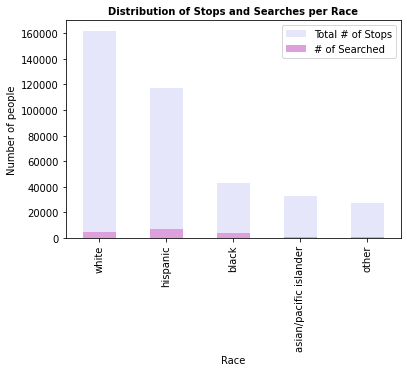

In [107]:
ax = searched.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
searched.plot(y="# of Searched", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Searches per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

Text(0.5, 1.0, 'Comparison between Percentage of Stops and Searches per Race')

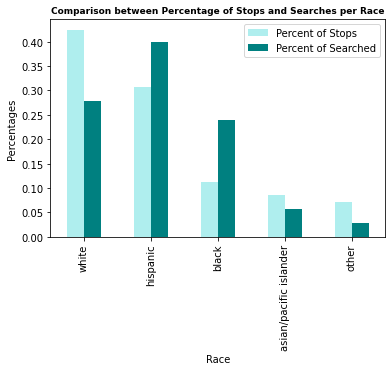

In [94]:
searched.plot(y= ['Percent of Stops',"Percent of Searched"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Searches per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [117]:
searched_person_groups = test[test['search_person'] == True]['subject_race'].value_counts().to_dict()
searched_person_groups

{'hispanic': 2683,
 'white': 2097,
 'black': 2008,
 'asian/pacific islander': 464,
 'other': 158}

In [118]:
percentage_searched_person = aspercent(test[test['search_person'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_searched_person

{'hispanic': 0.3620782726045884,
 'white': 0.28299595141700407,
 'black': 0.2709851551956815,
 'asian/pacific islander': 0.06261808367071525,
 'other': 0.021322537112010796}

In [124]:
searched_person = pd.DataFrame([demographic_groups, percentage_of_groups, searched_person_groups, percentage_searched_person],index=['Total # of Stops', 'Percent of Stops', '# of Searched (Person)', 'Percent of Searched (Person)']).T
index = searched_person.index
index.name = "Race"
searched_person.style.set_caption('Demographic Parity Fairness: Searched (Person)').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Searched (Person),Percent of Searched (Person)
Race,,,,
white,162226.000000,0.424906,2097.000000,0.282996
hispanic,117083.000000,0.306666,2683.000000,0.362078
black,42705.000000,0.111854,2008.000000,0.270985
asian/pacific islander,32541.000000,0.085232,464.000000,0.062618
other,27238.000000,0.071342,158.000000,0.021323


Text(0.5, 1.0, 'Distribution of Stops and Searches (Person) per Race')

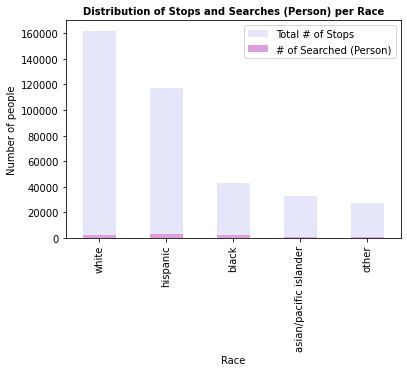

In [111]:
ax = searched_person.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
searched_person.plot(y="# of Searched (Person)", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Searches (Person) per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

Text(0.5, 1.0, 'Comparison between Percentage of Stops and Searches (Person) per Race')

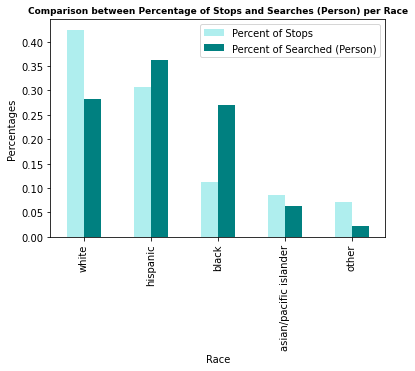

In [125]:
searched_person.plot(y= ['Percent of Stops',"Percent of Searched (Person)"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Searches (Person) per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [126]:
searched_vehicle_groups = test[test['search_vehicle'] == True]['subject_race'].value_counts().to_dict()
searched_vehicle_groups

{'hispanic': 4326,
 'white': 2509,
 'black': 2444,
 'asian/pacific islander': 534,
 'other': 279}

In [127]:
percentage_searched_vehicle = aspercent(test[test['search_vehicle'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_searched_vehicle

{'hispanic': 0.4286563614744352,
 'white': 0.24861276258422513,
 'black': 0.24217201743955608,
 'asian/pacific islander': 0.05291319857312723,
 'other': 0.027645659928656363}

In [128]:
searched_vehicle =pd.DataFrame([demographic_groups, percentage_of_groups, searched_vehicle_groups, percentage_searched_vehicle],index=['Total # of Stops', 'Percent of Stops', '# of Searched (Vehicles)', 'Percent of Searched (Vehicles)']).T
index = searched_vehicle.index
index.name = "Race"
searched_vehicle.style.set_caption('Demographic Parity Fairness: Searched (Vehicles)').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Searched (Vehicles),Percent of Searched (Vehicles)
Race,,,,
white,162226.000000,0.424906,2509.000000,0.248613
hispanic,117083.000000,0.306666,4326.000000,0.428656
black,42705.000000,0.111854,2444.000000,0.242172
asian/pacific islander,32541.000000,0.085232,534.000000,0.052913
other,27238.000000,0.071342,279.000000,0.027646


Text(0.5, 1.0, 'Distribution of Stops and Searches (Vehicles) per Race')

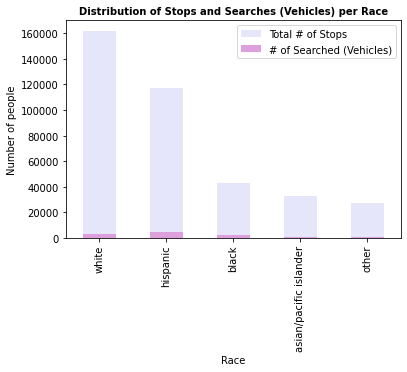

In [129]:
ax = searched_vehicle.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
searched_vehicle.plot(y="# of Searched (Vehicles)", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Searches (Vehicles) per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

Text(0.5, 1.0, 'Comparison between Percentage of Stops and Searches (Vehicles) per Race')

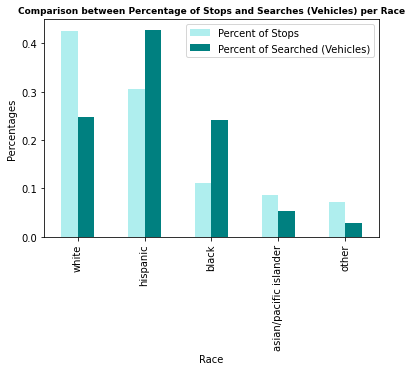

In [130]:
searched_vehicle.plot(y= ['Percent of Stops',"Percent of Searched (Vehicles)"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Searches (Vehicles) per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [131]:
arrested_groups = test[test['arrest_made'] == True]['subject_race'].value_counts().to_dict()
arrested_groups

{'white': 1771,
 'hispanic': 1714,
 'black': 857,
 'asian/pacific islander': 309,
 'other': 160}

In [132]:
percentage_arrested = aspercent(test[test['arrest_made'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_arrested

{'white': 0.3681147370609021,
 'hispanic': 0.356266888380794,
 'black': 0.178133444190397,
 'asian/pacific islander': 0.0642278112658491,
 'other': 0.03325711910205779}

In [133]:
arrested = pd.DataFrame([demographic_groups, percentage_of_groups, arrested_groups, percentage_arrested],index=['Total # of Stops', 'Percent of Stops', '# of Arrested', 'Percent of Arrested']).T
index = arrested.index
index.name = "Race"
arrested.style.set_caption('Demographic Parity Fairness: Arrested').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Arrested,Percent of Arrested
Race,,,,
white,162226.000000,0.424906,1771.000000,0.368115
hispanic,117083.000000,0.306666,1714.000000,0.356267
black,42705.000000,0.111854,857.000000,0.178133
asian/pacific islander,32541.000000,0.085232,309.000000,0.064228
other,27238.000000,0.071342,160.000000,0.033257


Text(0.5, 1.0, 'Distribution of Stops and Arrests per Race')

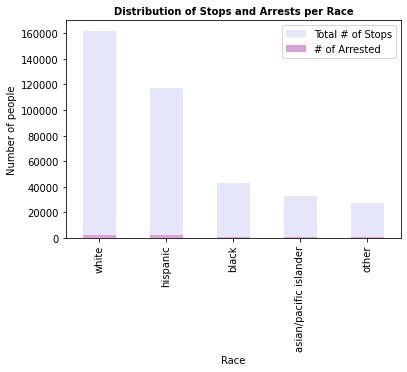

In [134]:
ax = arrested.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
arrested.plot(y="# of Arrested", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Arrests per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

Text(0.5, 1.0, 'Comparison between Percentage of Stops and Arrests per Race')

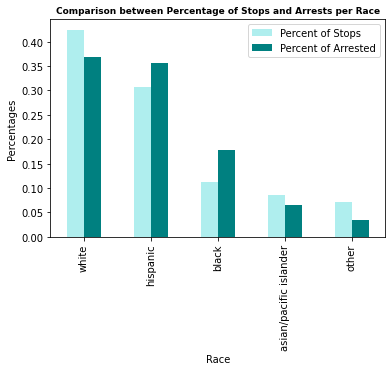

In [135]:
arrested.plot(y= ['Percent of Stops',"Percent of Arrested"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Arrests per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [136]:
citation_groups = test[test['citation_issued'] == True]['subject_race'].value_counts().to_dict()
citation_groups

{'white': 96631,
 'hispanic': 67787,
 'black': 20728,
 'asian/pacific islander': 17896,
 'other': 17359}

In [137]:
percentage_citation = aspercent(test[test['citation_issued'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_citation

{'white': 0.43843267498786304,
 'hispanic': 0.3075621253987051,
 'black': 0.09404676022341096,
 'asian/pacific islander': 0.08119745373206111,
 'other': 0.0787609856579598}

In [138]:
citation = pd.DataFrame([demographic_groups, percentage_of_groups, citation_groups, percentage_citation],index=['Total # of Stops', 'Percent of Stops', '# of Citations Issued', 'Percent of Citations Issued']).T
index = citation.index
index.name = "Race"
citation.style.set_caption('Demographic Parity Fairness: Citations Issued').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Citations Issued,Percent of Citations Issued
Race,,,,
white,162226.000000,0.424906,96631.000000,0.438433
hispanic,117083.000000,0.306666,67787.000000,0.307562
black,42705.000000,0.111854,20728.000000,0.094047
asian/pacific islander,32541.000000,0.085232,17896.000000,0.081197
other,27238.000000,0.071342,17359.000000,0.078761


Text(0.5, 1.0, 'Distribution of Stops and Citations Issued per Race')

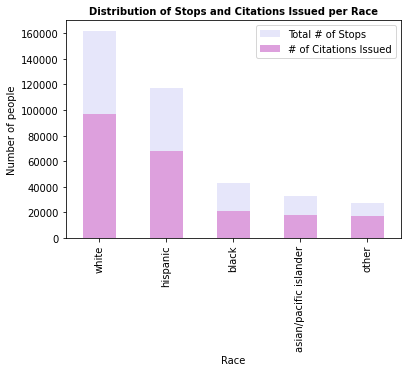

In [139]:
ax = citation.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
citation.plot(y="# of Citations Issued", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Citations Issued per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

Text(0.5, 1.0, 'Comparison between Percentage of Stops and Citations Issued per Race')

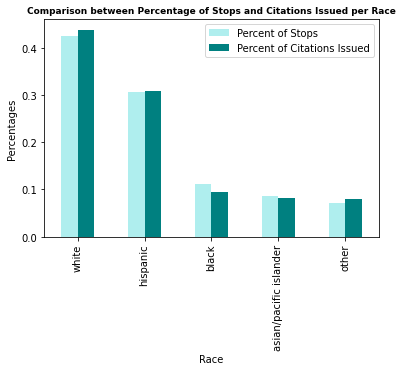

In [140]:
citation.plot(y= ['Percent of Stops',"Percent of Citations Issued"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Citations Issued per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [141]:
warning_issued_groups = test[test['warning_issued'] == True]['subject_race'].value_counts().to_dict()
warning_issued_groups

{'white': 50670,
 'hispanic': 33863,
 'black': 16780,
 'asian/pacific islander': 11985,
 'other': 7139}

In [142]:
percentage_warning_issued = aspercent(test[test['warning_issued'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_warning_issued

{'white': 0.42071788569957735,
 'hispanic': 0.28116774745302525,
 'black': 0.13932595464848843,
 'asian/pacific islander': 0.09951260825161702,
 'other': 0.05927580394729195}

In [143]:
warning = pd.DataFrame([demographic_groups, percentage_of_groups, warning_issued_groups, percentage_warning_issued],index=['Total # of Stops', 'Percent of Stops', '# of Warnings Issued', 'Percent of Warnings Issued']).T
index = warning.index
index.name = "Race"
warning.style.set_caption('Demographic Parity Fairness: Warnings Issued').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Warnings Issued,Percent of Warnings Issued
Race,,,,
white,162226.000000,0.424906,50670.000000,0.420718
hispanic,117083.000000,0.306666,33863.000000,0.281168
black,42705.000000,0.111854,16780.000000,0.139326
asian/pacific islander,32541.000000,0.085232,11985.000000,0.099513
other,27238.000000,0.071342,7139.000000,0.059276


Text(0.5, 1.0, 'Distribution of Stops and Warnings Issued per Race')

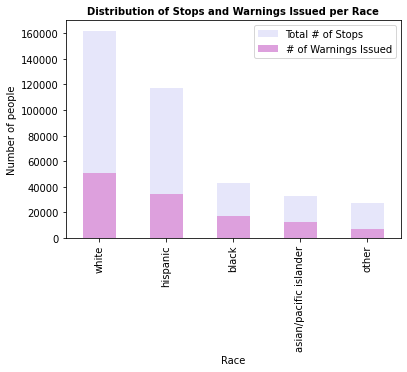

In [144]:
ax = warning.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
warning.plot(y="# of Warnings Issued", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Warnings Issued per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})
#warning.plot(y= ['# of Demographic Group',"# of Warnings Issued"], use_index=True, kind='bar')

Text(0.5, 1.0, 'Comparison between Percentage of Stops and Warnings Issued per Race')

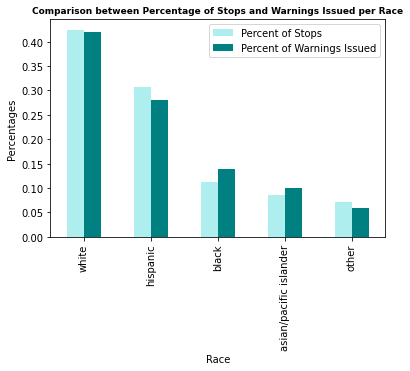

In [145]:
warning.plot(y= ['Percent of Stops',"Percent of Warnings Issued"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Warnings Issued per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

## Interpreting Results from Quantitative Measures

For “Demographic Parity Fairness: Searched,” we saw that out of the total number of police stops around 42.49% were White individuals, even though they were only searched 4510 times which accounted for 27.76% of all searches conducted by the police in San Diego within the dataset. There’s a substantial deviation from what should be expected where the demographics of people who ended up being searched after being stopped should be proportional to the demographics of the people who were stopped by the police. And it’s even greater for Hispanic and Black individuals. Where 30.67% of people stopped were Hispanic, but they were searched 6501 times which accounted for 40.02% of all searches conducted. Similarly, Black individuals accounted for 11.19% of all police stops, but were searched at a substantially high rate of 23.84% of the people who were ultimately searched. Almost every race demographic had a disparity between the rates they were stopped and the rates they were searched. Thus we noticed how the San Diego Police Department are generally unfair to and potentially biased against Hispanic and Black individuals, while they in turn favor White, Asian/Pacific Islander and other demographic groups as they are searched significantly less proportionally to their respective number of police stops.

Likewise, when interpreting the results for “Searched (Person)” and “Searched (Vehicles),” we still noticed the same substantive unfairness to Hispanic and Black individuals as the police ultimately search a larger percentage of these demographic groups than their total percentage of stops, especially when compared to their White and Asian/Pacific Islander counterparts. Our intention of looking into these more specific features was to find out whether the type of search varied in its results, and while it remained relatively similar there were some differences we noticed. Hispanic individuals were searched 36.21% out of the total person searches conducted, while they were searched 42.87% out of the total vehicle searches, a 6.66% difference. Oppositely Black individuals had a higher percentage of all vehicle searches, than their percentage of total person searches conducted. It is important to note that there were more vehicle searches conducted than person searches within this dataset. 

Taking a look at “Demographic Parity Fairness: Arrested,” we noticed the same general patterns between the investigations we conducted on searches. Under demographic parity-terms, the police continually are biased against Hispanic and Black individuals and are more likely to search and arrest these demographic groups than the percentage out of all police stops. In turn, the police continuously favor White, Asian/Pacific Islander, and other demographic groups throughout all their stops under this definition of fairness. However, unlike when analyzing the outcome of searches, the deviations between the rates each demographic group was stopped and the rates they were arrested are slightly less significant. 42.49% of individuals stopped were White, and 36.81% of individuals arrested were also White. 35.63% of people stopped were Hispanic, and Hispanic individuals accounted for 35.63% of people arrested. While police are still unfairly and more likely to arrest Hispanic and Black individuals, the disparity isn’t as huge as we noticed for searches. 

When looking at the figures for “Citations Issued” and “Warnings Issued,” every racial group is generally proportional in their respective percentages of police stops and the percentages of receiving a citation or a warning among every demographic group. Taking a closer look at the investigation done on citations, White individuals resulted in the largest increase from their expected percentage, however, it was only 1.35%. On the other hand, Black individuals resulted in the biggest decrease from their expected percentage, but the decrease was only 1.79%. These findings lead to us believing that the police were generally fair to every race when issuing a citation. Our investigation for warnings was on a similar note, however Black individuals resulted in the higher increase from their expected percentage at 2.74%, while Hispanic individuals resulted in the biggest decrease at 2.55% less than expected. While the deviations were slightly higher than we found for citations, it still is not significant enough to draw any major conclusions. Thus these results show that police in San Diego are fair to every race in general with slight bias in favor for Hispanic individuals, and slightly likelier to give Black individuals a warning. Overall the results for “Citations Issued” and “Warnings Issued” were reasonably fair in terms of Demographic Parity.

Since we mainly based our investigation on Demographic Parity, there are many limitations to the results we achieved. Specifically since Demographic Parity really only concerns the final outcome of the police stop rather than also focusing on the equality of treatment, the numbers at hand ultimately determine fairness in our analysis. In the future, we hope to continue expanding to other definitions of fairness to compare the results we obtained in order to get a better understanding of the inequality at hand. In addition, as mentioned above, factors like poorly defined variables in our “subject_race” column can lead to limiting our research to just a small set of demographic groups when there are groups like Native Americans, Multi-racial individuals, and more which would make our investigations into the San Diego Police Department more interesting to see how smaller minority groups are affected.


## References

​​Cortez, V. (2020, June 8). How to define fairness to detect and prevent discriminatory outcomes in machine learning. Medium. Retrieved May 8, 2022, from https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2 

 D'Ignazio, C., & Klein, L. (2020, March 16). Data Feminism. Retrieved May 8, 2022, from https://data-feminism.mitpress.mit.edu/ 
 
Fraenkel, A. (n.d.). Fairness & Algorithmic Decision making. Fairness and Algorithmic Decision Making. Retrieved May 8, 2022, from https://afraenkel.github.io/fairness-book/intro.html 

Kumar, D., Tang, E., & Zhong, M. (n.d.). (rep.). Machine Learning Analysis on the Fairness of the Boston Police Department Stop and Frisk Practices. 

Walsh, C. (2021, February 24). Solving racial disparities in policing. Harvard Gazette. Retrieved May 8, 2022, from https://news.harvard.edu/gazette/story/2021/02/solving-racial-disparities-in-policing/ 


Other Links: 
https://api.census.gov/data/2016/acs/acs1/variables.html

https://geographicdata.science/book/data/sandiego/sandiego_tracts_cleaning.html

https://afraenkel.github.io/fairness-algo-decision/assignments/inequity-analysis/